#### Trying out XGBoost since our Data is highly Imbalanced

We can either use approaches to oversample the minority class or we can use XGBoost and balance the positive and negative weights by setting scale_pos_weight to sum (negative instances) / sum (positive instances). </br>

All we are doing in the XGBoost is penalizing the model for predicting the majority class to balance the output. We will come to that later on how to do that.

In [1]:
#----main libraries----
import numpy as np
import pandas as pd

#----plotting libraries----
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#----regular expressions----
import re

#----model and support imports----
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from xgboost import XGBClassifier
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler, 
    PolynomialFeatures,
    KBinsDiscretizer
)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('Telco-Churn.csv')

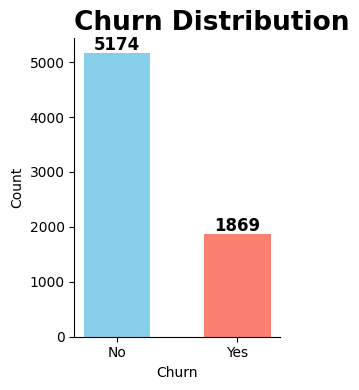

In [3]:
# Get the value counts for 'Churn' column
data_temp = df['Churn'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(3, 4))

# Plotting the bar chart
ax.bar(data_temp.index, data_temp, width=0.55, color=['skyblue', 'salmon'])

# Title and axis labels
ax.set_title('Churn Distribution', loc='left', fontsize=19, fontweight='bold')
ax.set_xlabel('Churn')
ax.set_ylabel('Count')

# Annotate each bar with its count value
for i, count in enumerate(data_temp):
    ax.text(i, count + 50, str(count), ha='center', fontsize=12, fontweight='bold')

# Hide spines on top and right sides
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()

In [4]:
spw = -(-df[df.Churn == "No"].shape[0]// df[df.Churn == "Yes"].shape[0])

print("XGBoost weight balancing ---> neg: {}, pos: {}, scale_pos_weight: {}".format(df[df.Churn == "No"].shape[0], df[df.Churn == "Yes"].shape[0], spw))

XGBoost weight balancing ---> neg: 5174, pos: 1869, scale_pos_weight: 3


#### Model configuration

We will use XGBoost and then use TensorFlow to see if we get better performance using a Neural Network. <br>
We will use SMOTE (synthetic minority oversampling technique) to correct for imbalance while using TensorFlow.

The mathematical goal of a machine learning algorithm is to find the optimal model parameters that minimize the cost function, also known as the loss function, over the training data. This is typically done through an optimization algorithm such as gradient descent, which iteratively updates the model parameters to minimize the cost function.

Let us first encode our dependent variable (i.e., convert it to 1 and 0):

In [5]:
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

We will now convert our categorical dependent variables into dummy variables (i.e., generate a separate column for each value and changing the values into 1 and 0):

In [6]:
df_dummy = pd.get_dummies(df)
df_dummy.head()

,SeniorCitizen,tenure,MonthlyCharges,Churn,customerID_0002-ORFBO,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-MHZWF,...,TotalCharges_995.35,TotalCharges_996.45,TotalCharges_996.85,TotalCharges_996.95,TotalCharges_997.65,TotalCharges_997.75,TotalCharges_998.1,TotalCharges_999.45,TotalCharges_999.8,TotalCharges_999.9
0,0,1,29.85,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,34,56.95,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,2,53.85,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,45,42.30,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,2,70.70,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Let us now check correlation between the various variables:

In [ ]:
matrix = np.triu(np.ones_like(df_dummy.corr()))
fig, ax = plt.subplots(figsize=(25,25),dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df_dummy.corr(), mask= matrix, cmap="coolwarm", annot = True, fmt = '.1f', center = 0,annot_kws={"fontsize":10})

Finding redundant features

In [ ]:
from scipy.stats import pearsonr

# Define the correlation threshold
correlation_threshold = 0.8

# Create an empty list to store correlated pairs of features
correlated_pairs = []

# Calculate the correlation matrix
corr_matrix = df_dummy.corr().abs()

# Loop through the upper triangle of the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        # If the correlation exceeds the threshold
        if corr_matrix.iloc[i, j] > correlation_threshold:
            # Append the pair of features to the list
            correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

# Print the correlated pairs of features
print(correlated_pairs)